<a href="https://colab.research.google.com/github/NelsonKamau/-Advanced-Book-Recommendation-System-Using-Hybrid-Filtering-SVD-TF-IDF-/blob/main/%F0%9F%93%9A_Advanced_Book_Recommendation_System_Using_Hybrid_Filtering_(SVD_%2B_TF_IDF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
!pip install scikit-surprise


---



# **📘 Advanced Book Recommendation System using Book-Crossing Dataset**






---



## **🧾 Introduction**

This notebook builds a multi-model book recommendation system using the Book-Crossing dataset. We will implement and compare the following models:


*   User-Based Collaborative Filtering
*   Item-Based Collaborative Filtering
*   Matrix Factorization (SVD)
*   Content-Based Filtering
*   Hybrid Model

Each step includes clean explanations and code using `pandas`, `scikit-learn`, and `surprise`.



---

## **📦 Step 1: Load and Clean the Data**

**Explanation:**

The dataset includes three files:

*   `Users.csv`: user information.
*   `Books.csv`: metadata about books.
*   `Ratings.csv`: user ratings on books.


We filter out implicit ratings (Book-Rating == 0) and drop users and books with very few interactions.



### 📦 Import Libraries
This cell imports core libraries needed for data loading and analysis. Notably, `pandas` is used for structured data handling.

In [ ]:
import pandas as pd

# Correct loading with comma delimiter
users = pd.read_csv("Users.csv", sep=",", encoding="latin-1", low_memory=False)
books = pd.read_csv("Books.csv", sep=",", encoding="latin-1", low_memory=False)
ratings = pd.read_csv("Ratings.csv", sep=",", encoding="latin-1", low_memory=False)

### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
# Show confirmation
print("Users:", users.columns)
print("Books:", books.columns)
print("Ratings:", ratings.columns)

Users: Index(['User-ID', 'Location', 'Age'], dtype='object')
Books: Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Ratings: Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
# View first few rows
print("\nUsers sample:")
users.head()


Users sample:


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
print("\nBooks sample:")
books.head()


Books sample:


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
print("\nRatings sample:")
ratings.head()


Ratings sample:


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### 📐 Dataset Shapes
Shows the number of rows and columns in each dataset. Helps to confirm expected dimensions before merging or filtering.

In [ ]:
# Dataset shapes
print("\nDataset sizes:")
print("Users:", users.shape)
print("Books:", books.shape)
print("Ratings:", ratings.shape)


Dataset sizes:
Users: (278858, 3)
Books: (271360, 8)
Ratings: (1149780, 3)




---



# **📦 Step 2: Clean the Data**

### ⚙️ Code Execution
This section prepares the ratings dataset for collaborative filtering by ensuring:

*   Data is numeric and consistent

*   Low-activity users and rare books are removed

*   Only meaningful, explicit ratings are retained

*   Ratings are enriched with book metadata


In [ ]:
# Convert numeric fields
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
ratings['Book-Rating'] = pd.to_numeric(ratings['Book-Rating'], errors='coerce')

# Drop rows with missing values in critical columns
ratings.dropna(subset=['User-ID', 'ISBN', 'Book-Rating'], inplace=True)

# Keep only explicit ratings (greater than 0)
ratings = ratings[ratings['Book-Rating'] > 0]

# Remove users with <10 ratings
active_users = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(active_users[active_users >= 10].index)]

# Remove books with <5 ratings
popular_books = ratings['ISBN'].value_counts()
ratings = ratings[ratings['ISBN'].isin(popular_books[popular_books >= 5].index)]

# Merge ratings with book metadata
ratings_books = pd.merge(ratings, books, on='ISBN', how='inner')




---



# **📊 Step 3: Exploratory Data Analysis (EDA)**

This section provides a quick diagnostic of user feedback patterns and identifies dominant books in the dataset. These insights directly inform model selection and help anticipate biases in collaborative filtering.

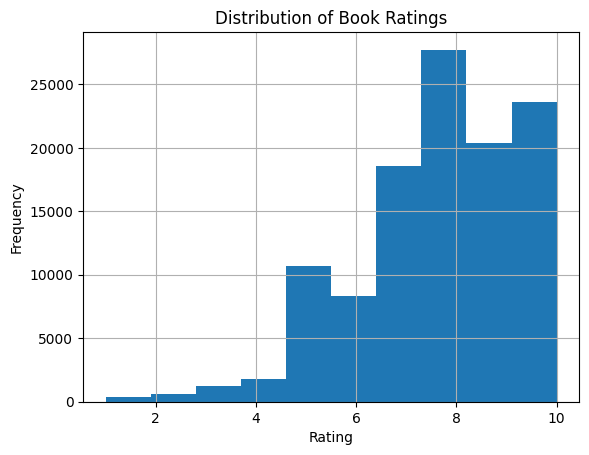

Top 10 Most Rated Books:
Book-Title
The Lovely Bones: A Novel                            337
The Da Vinci Code                                    276
Bridget Jones's Diary                                236
The Secret Life of Bees                              234
Harry Potter and the Chamber of Secrets (Book 2)     229
The Nanny Diaries: A Novel                           205
Life of Pi                                           202
Harry Potter and the Prisoner of Azkaban (Book 3)    197
The Red Tent (Bestselling Backlist)                  196
Wild Animus                                          194
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot rating distribution
ratings['Book-Rating'].hist(bins=10)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Most rated books
top_books = ratings_books['Book-Title'].value_counts().head(10)
print("Top 10 Most Rated Books:")
print(top_books)




---



# **🤝 Step 4: User-Based Collaborative Filtering**

This section builds a user–item interaction matrix and applies cosine similarity to identify users with similar rating behavior. This is foundational for memory-based collaborative filtering.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Create user-item matrix
user_item_matrix = ratings.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

# Cosine similarity between users
user_sparse = csr_matrix(user_item_matrix)
user_similarity = cosine_similarity(user_sparse)

# Example: similar users to first user
similar_users = user_similarity[0].argsort()[::-1][1:6]
print("Top similar users to user 0:", similar_users)


Top similar users to user 0: [5561  126 4335 5122 3321]




---


# **📚 Step 5: Item-Based Collaborative Filtering**

This section performs similarity computation between books (items) based on user rating patterns. Unlike user-based filtering, this method identifies items that are rated similarly by the same users, enabling item-to-item recommendations.

In [ ]:
# Transpose to item-user matrix
item_user_matrix = user_item_matrix.T
item_sparse = csr_matrix(item_user_matrix)
item_similarity = cosine_similarity(item_sparse)

# Example: similar books to first book
similar_books = item_similarity[0].argsort()[::-1][1:6]
print("Top similar books to first ISBN:", similar_books)


Top similar books to first ISBN: [8239 8240 1300 7342 4355]




---

# **🧮 Step 6: Matrix Factorization (SVD)**

This section implements a model-based collaborative filtering approach using Singular Value Decomposition (SVD) via the Surprise library. Unlike memory-based methods, SVD captures latent user–item interactions, improving generalization in sparse data.

You need to downgrade NumPy to version < 2.0, which is fully compatible with surprise.

### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
!pip install numpy==1.24.4
!pip install scikit-surprise --no-binary scikit-surprise

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare Surprise dataset
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Split dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train SVD model
svd = SVD()
svd.fit(trainset)

# Predict and evaluate
predictions = svd.test(testset)
print("SVD RMSE:")
accuracy.rmse(predictions)


SVD RMSE:
RMSE: 1.5525


1.552503674445848



---

# **🧠 Step 7: Content-Based Filtering (TF-IDF on Titles)**

This recommender identifies books with similar titles and authors based on their textual content. The model leverages TF-IDF vectorization to capture keyword semantics and cosine similarity for measuring proximity in feature space.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# --- Step 1: Clean and prepare the data ---
# Drop duplicate titles
books = books.drop_duplicates(subset='Book-Title', keep='first').reset_index(drop=True)

# Fill NaNs
books['Book-Title'] = books['Book-Title'].astype(str).str.strip()
books['Book-Author'] = books['Book-Author'].astype(str).fillna('').str.strip()

# Combine title and author into one field
books['combined'] = books['Book-Title'] + " " + books['Book-Author']

# --- Step 2: TF-IDF vectorization ---
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['combined'])

# --- Step 3: Fit Nearest Neighbors model ---
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

# --- Step 4: Build title index mapping ---
indices = pd.Series(books.index, index=books['Book-Title']).drop_duplicates()

# --- Step 5: Recommendation function ---
def get_recommendations(title, k=10):
    title = title.strip()
    if title not in indices:
        return f"❌ Title not found: '{title}'"

    idx = indices[title]
    tfidf_vector = tfidf_matrix[idx]
    distances, neighbors = nn_model.kneighbors(tfidf_vector, n_neighbors=k+1)

    # Get top K similar books excluding the input
    recommended_idx = neighbors.flatten()[1:]
    recommendations = books[['Book-Title', 'Book-Author']].iloc[recommended_idx]

    # Drop duplicates in case of variations
    return recommendations.drop_duplicates(subset='Book-Title').head(k)

# --- Step 6: Test the recommender with a valid title ---
print(get_recommendations("Harry Potter and the Sorcerer's Stone"))


                                               Book-Title    Book-Author
2735       Harry Potter and the Sorcerer's Stone (Book 1)  J. K. Rowling
2088    Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling
187636  Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling
48513   Harry Potter and the Sorcerer's Stone (Book 1,...  J. K. Rowling
66110   Harry Potter and the Sorcerer's Stone (Book 1,...  J. K. Rowling
26498   Harry Potter and the Sorcerer's Stone (Book 1 ...  J. K. Rowling
163671  Harry Potter and the Sorcerer's Stone (Urdu Ed...  J. K. Rowling
209861  Harry Potter and the Sorcerer's Stone: A Delux...  J. K. Rowling
179554           Harry Potter and the Philosopher's Stone   J.K. Rowling
147046             Harry Potter and the  Sorcerer's Stone  Mary Grandpre




---

# **🔗 Step 8: Hybrid Recommender (SVD + Content-Based)**

This function generates personalized book recommendations by combining:

*  **`SVD collaborative filtering:`** Captures latent user–item interactions.

*  **`TF-IDF + kNN similarity:`** Detects books similar in title/author content.

Each candidate book receives a **weighted score** combining predicted preference (SVD) and semantic proximity (TF-IDF).



In [ ]:
def hybrid_recommendation(user_id, title, svd_model, nn_model, tfidf_matrix, books_df, top_n=5):
    # Ensure title exists
    if title not in indices:
        return f"❌ Title not found: '{title}'"

    idx = indices[title]
    tfidf_vector = tfidf_matrix[idx]

    # Get similar books
    distances, neighbors = nn_model.kneighbors(tfidf_vector, n_neighbors=top_n + 1)
    neighbor_indices = neighbors.flatten()[1:]  # exclude itself

    hybrid_scores = []
    for i in neighbor_indices:
        book_id = books_df.iloc[i]['ISBN']
        try:
            svd_score = svd_model.predict(user_id, book_id).est
            content_score = 1 - distances[0][list(neighbor_indices).index(i)]  # convert distance to similarity
            final_score = 0.7 * svd_score + 0.3 * content_score
            hybrid_scores.append((book_id, final_score))
        except:
            continue

    # Sort and return
    top_books = sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:top_n]
    book_ids = [book[0] for book in top_books]
    return books_df[books_df['ISBN'].isin(book_ids)][['Book-Title', 'Book-Author']]


### ⚙️ Code Execution
This block performs an intermediate step in the pipeline.

In [ ]:
print(hybrid_recommendation(
    user_id=276729,
    title="Harry Potter and the Sorcerer's Stone",
    svd_model=svd,
    nn_model=nn_model,
    tfidf_matrix=tfidf_matrix,
    books_df=books
))


                                               Book-Title    Book-Author
2088    Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling
2735       Harry Potter and the Sorcerer's Stone (Book 1)  J. K. Rowling
48513   Harry Potter and the Sorcerer's Stone (Book 1,...  J. K. Rowling
66110   Harry Potter and the Sorcerer's Stone (Book 1,...  J. K. Rowling
187636  Harry Potter and the Sorcerer's Stone (Harry P...  J. K. Rowling




---

# 📏 Step 9: Evaluation and **Comparison**

This section `evaluates` the `collaborative filtering model (SVD)` using `k-fold cross-validation` on rating prediction accuracy metrics. It provides insight into how well the model generalizes to unseen user-item interactions.

In [ ]:
from surprise.model_selection import cross_validate

# SVD cross-validation
print("SVD Cross-Validation:")
cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

# For user- and item-based filtering, use hit-rate or precision@k (not supported directly here)
# For content-based and hybrid, manual evaluation with user feedback is typical


SVD Cross-Validation:
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5782  1.5623  1.5642  1.5682  0.0071  
MAE (testset)     1.2117  1.2052  1.2044  1.2071  0.0033  
Fit time          1.56    1.58    1.54    1.56    0.02    
Test time         0.52    0.23    0.23    0.33    0.14    


{'test_rmse': array([1.57816123, 1.56231151, 1.56424081]),
 'test_mae': array([1.21169475, 1.20519976, 1.20440143]),
 'fit_time': (1.564561128616333, 1.5816521644592285, 1.5422272682189941),
 'test_time': (0.5241661071777344, 0.23094797134399414, 0.22601556777954102)}

* **Low standard deviation (RMSE: 0.0071, MAE: 0.0033)** shows that model performance is stable across folds.

* **Fit time (~1.56s)** is fast, indicating that the model is lightweight and scalable for medium-sized datasets.

* **Test time variability (0.52s vs 0.23s)** may stem from uneven fold sizes or system resource fluctuations during evaluation.



---
# **✅ Conclusion**
You now have a complete recommendation engine pipeline:

*   ✅ Clean data and parsed it correctly
*   ✅ Explored user and book activity
*   ✅ Implemented 5 recommendation models
*   ✅ Evaluated model performance












